## Under Sampling using Instance Hardness Method

# Instance Hardness Threshold

Instance hardness is the probability of an observation being miss-classified. So in other words, the instance hardness is 1 minus the probability of the class. For class 1:

- **instance hardness = 1 - p(1)**

The instance hardness depends on the algorithm used in the classification and in class separability.

## Instance Hardness Filtering

Instance Hardness filtering consists in determining the instance hardness and removing the observations that are harder to classify. In other words, removing the observations with high **instance hardness** or low **class probability**. The question is, how to determine the threshold.

In this notebook we will:

- Determine the instance hardness of observations
- Filter observations from the majority class based of an arbitrary threshold
- Filter observations from the majority class as proposed by Imbalanced-learn
- Use imbalance-learn to implement Instance Hardness

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict
)

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# for metrics
from sklearn.metrics import roc_auc_score

# from imblearn
from imblearn.under_sampling import InstanceHardnessThreshold

## create simulated data

In [8]:
# function to create simulated data
# the user can specify the number of classes
# the imbalance, and how well separated the classes are
def create_data(weights,sep,n_classes):
    
    X,y = make_classification(n_samples=1000,
                              n_features=2,
                              n_redundant=0,
                              n_classes=n_classes,
                              n_clusters_per_class=1,
                              weights=weights,
                              class_sep=sep, # how separate the classes are
                              random_state=1)
    
    X = pd.DataFrame(X, columns=['varA','varB'])
    y = pd.Series(y)
    
    return X,y

Data Shapes:
(1000, 2) (1000,)
Balance Ratio:
0    894
1    106
dtype: int64


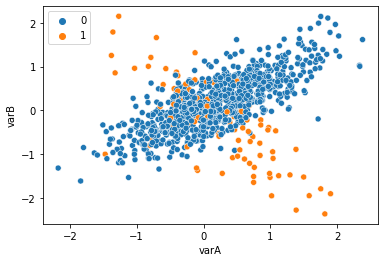

In [9]:
# create a dataset and try plotting

X,y = create_data(weights=[0.90], sep=0.2, n_classes=2)

# check the data 
print('Data Shapes:')
print(X.shape, y.shape)

# check the balance ratio
print('Balance Ratio:')
print(y.value_counts())

# plot
sns.scatterplot(data = X, x = 'varA', y ='varB', hue=y)
plt.show()
    

- We can see some overlap in the two classes

## Train using Random Forest
We will use Random Forests to determine instance hardness. We will do so with cross-validation, to try and perform the procedure as closely as possible to the imbalanced-learn implementation.

More details on the sklearn functions we use:

- [StratifiedKFold](https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.StratifiedKFold.html)
- [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)

In [10]:
# setting up Stratified Cross validation scheme
skf = StratifiedKFold(n_splits=3,   # 3 Fold Cross validation
                      shuffle=True,
                      random_state=1)

skf

StratifiedKFold(n_splits=3, random_state=1, shuffle=True)

In [11]:
# set up Random Forest Classifier
rf = RandomForestClassifier(n_estimators=5, max_depth=1, random_state=1)

## Calculating Instance Hardness value

In [12]:
# getting the predictions from the Random Forest with cross validtion
probs = cross_val_predict(rf,
                          X,
                          y,
                          cv=skf,
                          n_jobs=2,
                          method='predict_proba')
probs
# this returns an array of probabilities w.r.t to class 0 and class 1

array([[0.88956575, 0.11043425],
       [0.90398721, 0.09601279],
       [0.89625007, 0.10374993],
       ...,
       [0.84881175, 0.15118825],
       [0.88956575, 0.11043425],
       [0.89625007, 0.10374993]])

In [14]:
# lets convert this probs into a DataFrame
probs = pd.DataFrame(probs, columns = ['p(0)','p(1)'])
probs

,p(0),p(1)
0,0.889566,0.110434
1,0.903987,0.096013
2,0.896250,0.103750
3,0.896250,0.103750
4,0.903987,0.096013
...,...,...
995,0.889566,0.110434
996,0.889566,0.110434
997,0.848812,0.151188
998,0.889566,0.110434


The class 0 here is the majority class. So we want to under-sample that class. We can do so by removing observations with low p(0), which is the same as saying high instance hardness. Remember that instance hardness is 1 - the probability of the class.

## Under-sample observations from the majority class

### Arbitrary threshold

In [16]:
# checking the probs statistics to pick the arbitrary threshold
probs.describe()

,p(0),p(1)
count,1000.000000,1000.000000
mean,0.889839,0.110161
std,0.052598,0.052598
min,0.252222,0.060097
25%,0.889566,0.096013
50%,0.896250,0.103750
75%,0.903987,0.110434
max,0.939903,0.747778


We see that most observations of the majority class show p(0) > 0.88. We can try and remove observations under 0.85. This is arbitrary of course, we would have to try several thresholds and see what works best for our data.

In [23]:
y.value_counts()

0    894
1    106
dtype: int64

In [26]:
# now we can remove either
# those observations whose probability is less than 0.85
# or whose instance hardness is 1 - prob = 1 - 0.85 
# these both are the same

# so, lets remove those observations only from the majority class (class 0) 
# whose prob returned by RF is less 0.85

condition = (y == 0) & (probs['p(0)'] <= 0.85)

# getting the filtered data from X
filtered = X.loc[condition]
filtered.shape

(27, 2)

Not many observations will be removed, probably because the model is doing a fair good job at classifying the classes. 

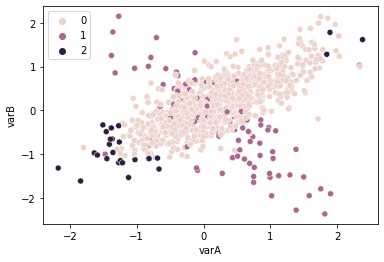

In [28]:
# lets identify which observations will be removed
sns.scatterplot(data=X, x = 'varA', y ='varB', hue=y + 2*condition)
plt.show()

The darker colored observations are the ones that will be removed

In [31]:
# dropping the hard instances
X_resampled = X.drop(filtered.index)
y_resampled = y.drop(filtered.index)

X_resampled.shape, y_resampled.shape

((973, 2), (973,))

So, 27 observations are removed

In [32]:
# target balance after filtering
y_resampled.value_counts()

0    867
1    106
dtype: int64

<AxesSubplot:xlabel='varA', ylabel='varB'>

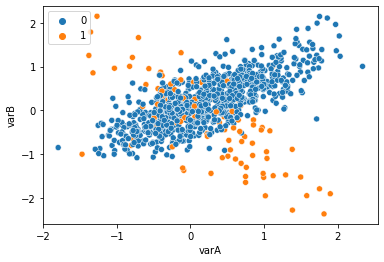

In [33]:
# plot filtered data

sns.scatterplot(data=X_resampled, x = 'varA', y ='varB', hue=y_resampled)

## Lets check using Logistic Regression

In [34]:
log = LogisticRegression(max_iter=500,random_state=0,n_jobs=2)

In [35]:
# perform cross validation using our log model

probs_log = cross_val_predict(log, X, y, cv = skf, n_jobs=2, method='predict_proba')
probs_log

array([[0.76385359, 0.23614641],
       [0.95742797, 0.04257203],
       [0.89847319, 0.10152681],
       ...,
       [0.858836  , 0.141164  ],
       [0.90591221, 0.09408779],
       [0.9036015 , 0.0963985 ]])

In [36]:
probs_log = pd.DataFrame(probs_log, columns = ['p(0)', 'p(1)'])
probs_log

,p(0),p(1)
0,0.763854,0.236146
1,0.957428,0.042572
2,0.898473,0.101527
3,0.941008,0.058992
4,0.927835,0.072165
...,...,...
995,0.945605,0.054395
996,0.953122,0.046878
997,0.858836,0.141164
998,0.905912,0.094088


In [38]:
# checking probability data statistics
probs_log.describe()

,p(0),p(1)
count,1000.000000,1000.000000
mean,0.894971,0.105029
std,0.072784,0.072784
min,0.127289,0.004142
25%,0.880422,0.069682
50%,0.908899,0.091101
75%,0.930318,0.119578
max,0.995858,0.872711


In [40]:
# lets set a similar arbitrary threshold value to filter the observations 
# threshold value of <= 0.85

cond = (y == 0) & (probs_log['p(0)'] <= 0.85)

filtered_log = X.loc[cond]
filtered_log.shape

(74, 2)

<AxesSubplot:xlabel='varA', ylabel='varB'>

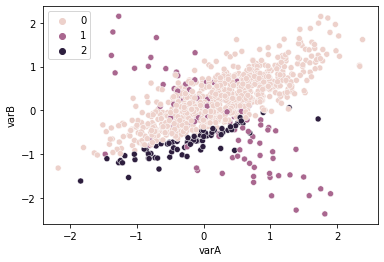

In [41]:
# plotting the filtered observations and the original ones

sns.scatterplot(data = X, x ='varA', y ='varB', hue = y + 2*cond)

- We have few more observations to be removed given by the Logistic model as compared to the ones given by the RF model
- Also, the observations that were identified by these two models seems to be from different areas of the spread

## Under-sample data to match balancing ratio

- So far we were using an arbitraty threshold value by checking the statistics of the probability distribution
- Now lets try to find a threshold that equilibrates the balancing ratio.

In [51]:
# first lets check the target value counts and balance ratios
y.value_counts()

0    894
1    106
dtype: int64

In [52]:
len(y[y == 0])/len(y[y == 1])

8.433962264150944

- We can see for an observations from class 1, there are around 8.4 observations from class 0

In [74]:
# we could also arbitrarily select the top 106 observations from class 0 as follows

probs[y==0]['p(0)'].sort_values(ascending=False).head(106)

# another way
# probs[y==0].sort_values(by='p(0)', ascending=False).head(106)

655    0.939903
768    0.939903
404    0.939903
279    0.939903
857    0.939903
         ...   
553    0.903987
336    0.903987
369    0.903987
521    0.903987
410    0.903987
Name: p(0), Length: 106, dtype: float64

But, as we can see from the plot, a lot of the observations have a similar probability value, so why should we keep some and remove others?

To avoid this, imbalanced-learn determines the threshold based on the imbalance, and then selects all observations above that threshold. This is how:

In [75]:
# number of samples needed  = 106
n_samples = 106

# total number of samples = 894
n_total_samples = 894

# we will calculate the percentile on which we find these number of observations
perc = n_samples/n_total_samples
perc

0.1185682326621924

In [76]:
# we want the observations with the highest p(0)
# so we are looking at the top 11% and not at the bottom 11%

# thus we need to find the top percentile which is 1 - perc

perc = (1 - perc) * 100

perc

88.14317673378076

In [77]:
# lets find the threshold at which we find 88% of the observations
threshold = np.percentile(probs[y==0]['p(0)'], perc)
threshold

0.9039872125121304

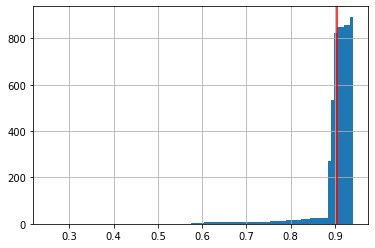

In [79]:
# lets visually check this threshold value
probs[y==0]['p(0)'].hist(cumulative=True, bins=100)
plt.axvline(x=threshold, c = 'red')

In [82]:
# now we will remove observations from class 0
# where the probability is below the threshold

cond = (y==0) & (probs['p(0)'] < threshold)

filtered = X.loc[cond]
filtered.shape

(534, 2)

<AxesSubplot:xlabel='varA', ylabel='varB'>

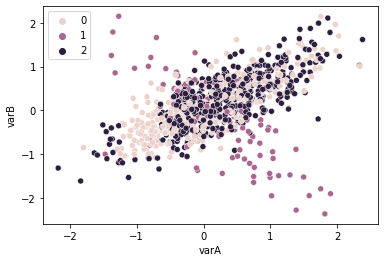

In [83]:
# now lets plot and check visually
sns.scatterplot(data= X, x ='varA', y ='varB', hue = y + 2*cond)

- Now we have more observations that are being filtered out and to remove

In [84]:
# removing these filtered observations from our data
X_resampled = X.drop(filtered.index)
y_resampled = y.drop(filtered.index)

In [85]:
X_resampled.shape, y_resampled.shape

((466, 2), (466,))

In [86]:
# check the target balance after filtering
y_resampled.value_counts()

0    360
1    106
dtype: int64

As we can see, we did reduce the number of observations from the majority, but we did not achieve the desired balance, because there are many observations that have a similar probability value. So this algorithm retains them all.

<AxesSubplot:xlabel='varA', ylabel='varB'>

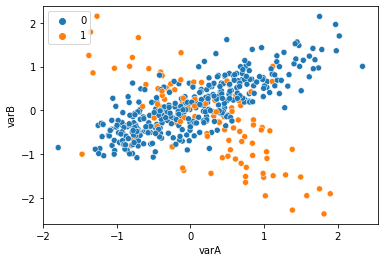

In [87]:
# plot the resampled data
sns.scatterplot(data = X_resampled, x ='varA', y ='varB', hue=y_resampled)

### Instance hardness with imbalanced-learn

Let's repeat the exercise but now using imbalanced-learn

[InstanceHardnessThreshold](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.InstanceHardnessThreshold.html)

In [89]:
# setting up instance Hardness threshold

iht = InstanceHardnessThreshold(estimator=rf,
                          sampling_strategy='auto', # to remove from the majority class
                          cv=3, # 3-fold cross validation
                          n_jobs=2,
                          random_state=1)
X_resampled, y_resampled = iht.fit_resample(X,y)
X_resampled.shape, y_resampled.shape

((283, 2), (283,))

In [90]:
# Original shape of the data
X.shape, y.shape

((1000, 2), (1000,))

In [91]:
# balancing ratio
y_resampled.value_counts()

0    177
1    106
dtype: int64

<AxesSubplot:xlabel='varA', ylabel='varB'>

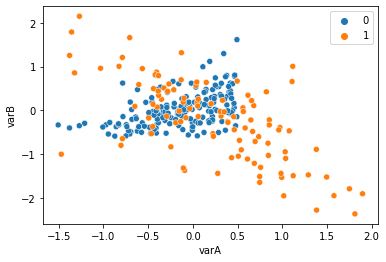

In [92]:
# plot
sns.scatterplot(data= X_resampled, x='varA', y='varB', hue=y_resampled)

In [95]:
# indexes of the samples that are retain
iht.sample_indices_

array([  4,   5,   7,  40,  42,  45,  46,  61,  62,  64,  66,  73,  79,
        80,  90,  93,  99, 107, 110, 111, 122, 123, 124, 127, 129, 131,
       134, 145, 148, 157, 160, 164, 185, 190, 192, 201, 207, 209, 215,
       220, 231, 232, 234, 250, 259, 260, 265, 268, 270, 275, 276, 277,
       280, 284, 286, 293, 295, 296, 307, 313, 315, 318, 333, 336, 349,
       363, 364, 369, 376, 377, 387, 390, 392, 395, 405, 409, 410, 416,
       419, 422, 430, 433, 447, 452, 455, 457, 461, 466, 472, 477, 479,
       481, 482, 488, 489, 493, 501, 504, 519, 521, 534, 543, 546, 550,
       553, 555, 563, 574, 575, 581, 601, 605, 607, 608, 621, 622, 626,
       630, 632, 633, 645, 646, 649, 650, 651, 662, 674, 677, 690, 701,
       705, 712, 728, 734, 735, 737, 740, 741, 750, 760, 761, 764, 782,
       799, 807, 808, 811, 816, 818, 830, 831, 832, 833, 838, 841, 844,
       845, 855, 859, 865, 869, 872, 879, 881, 901, 909, 923, 926, 927,
       941, 943, 961, 966, 967, 974, 980, 982,   0,   8,  14,  1

In [96]:
# let's find the removed observations

removed_obs = [0 if x in iht.sample_indices_ else 1 for x in X.index ]

len(removed_obs), np.sum(removed_obs)

(1000, 717)

- So, 717 observations are removed

<AxesSubplot:xlabel='varA', ylabel='varB'>

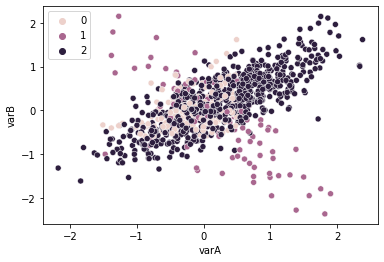

In [97]:
#plot the original data highlighting removed observations

sns.scatterplot(data= X, x ='varA', y='varB', hue = y + 2*pd.Series(removed_obs))

## Instance Hardness Threshold

### Real data - Performance comparison

Does it work well with real datasets? 

Well, it will depend on the dataset, so we need to try and compare the models built on the whole dataset, and that built on the under-sampled dataset.

In [98]:
# sampling to only 10000 observations to speed up the computation
df = pd.read_csv('kdd2004.csv').sample(10000, random_state=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
88984,71.15,32.43,1.29,28.0,-39.0,1639.2,-1.33,1.03,9.5,-82.5,...,1054.2,0.80,3.28,0.0,-60.0,623.1,0.11,0.25,0.31,-1
140218,30.72,36.17,-0.24,-6.5,3.5,1249.7,0.45,0.32,8.0,-75.0,...,1524.8,-2.70,0.75,-3.0,-20.0,1.2,0.74,0.56,0.29,-1
91280,11.84,42.86,0.21,-25.0,26.5,2346.3,0.10,-0.77,-38.0,-62.0,...,3392.7,-2.76,1.02,21.0,-106.0,1236.6,0.01,0.56,0.27,-1
22351,26.67,28.57,-0.57,0.5,50.5,1195.0,0.69,0.16,-3.5,-43.0,...,1301.9,1.10,0.09,7.0,-29.0,263.0,0.51,0.58,0.61,-1
27966,40.32,26.34,-0.97,-57.5,79.5,4939.5,-0.80,0.56,7.5,-117.5,...,3544.6,0.84,0.02,15.0,-196.0,1667.2,0.16,0.14,0.28,-1


In [99]:
df.shape

(10000, 75)

In [100]:
# check the target values ratios
df['target'].value_counts()

-1    9900
 1     100
Name: target, dtype: int64

In [101]:
df['target'].value_counts()/len(df)

-1    0.99
 1    0.01
Name: target, dtype: float64

## split the data

In [102]:
X_train, X_test, y_train,y_test = train_test_split(df.drop('target', axis = 1),
                                                  df['target'],
                                                  test_size=0.3,
                                                  random_state=0)
X_train.shape, X_test.shape

((7000, 74), (3000, 74))

In [103]:
# set up the models to compare
# remember that we should calculate instance hardness
# with the same models we intend to train as final model

logit = LogisticRegression(random_state=0, max_iter=1000)

rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=2)

In [104]:
# resample using
# instance hardness threshold with logistic regression

iht_logit = InstanceHardnessThreshold(
    estimator=logit,
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,
    n_jobs=4, # have 4 processors in my laptop
    cv=3)  # cross validation fold

X_logit, y_logit = iht_logit.fit_resample(X_train, y_train)

In [105]:
# resample using
# instance hardness threshold with Random Foreset

iht_rf = InstanceHardnessThreshold(
    estimator=logit,
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,
    n_jobs=4, # have 4 processors in my laptop
    cv=3)  # cross validation fold

X_rf, y_rf = iht_rf.fit_resample(X_train, y_train)

In [106]:
# compare the shapes of the resampled data
X_train.shape, X_logit.shape, X_rf.shape

((7000, 74), (138, 74), (138, 74))

## Model performance on original and condensed resample data

### Random Forest

In [107]:
def create_randomForest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200,
                                n_jobs=2,
                                random_state=39,
                                max_depth=4)
    
    rf.fit(X_train, y_train)
    probs_train = rf.predict_proba(X_train)
    probs_test = rf.predict_proba(X_test)
    
    # get metrics
    print('roc auc score for train data: {}'.format(roc_auc_score(y_train, probs_train[:,1])))
    print('roc auc score for test data: {}'.format(roc_auc_score(y_test, probs_test[:,1])))

In [108]:
# for Original DataSet
create_randomForest(X_train, X_test, y_train, y_test)

roc auc score for train data: 0.9882799186180969
roc auc score for test data: 0.9809319962189941


In [109]:
# for re sampled dataset
create_randomForest(X_rf, X_test, y_rf, y_test)

roc auc score for train data: 0.9991598403696703
roc auc score for test data: 0.9574854137919796


### Logistic Regression

In [112]:
def create_log(X_train, X_test, y_train, y_test):
    
    log = LogisticRegression(max_iter=10000, random_state=0, solver='saga', n_jobs=2)
    
    log.fit(X_train, y_train)
    probs_train = log.predict_proba(X_train)
    probs_test = log.predict_proba(X_test)
    
    # get metrics
    print('roc auc score for train data: {}'.format(roc_auc_score(y_train, probs_train[:,1])))
    print('roc auc score for test data: {}'.format(roc_auc_score(y_test, probs_test[:,1])))

In [113]:
# for original data
create_log(X_train, X_test, y_train, y_test)

roc auc score for train data: 0.9290229362306295
roc auc score for test data: 0.9144927693695063


In [115]:
# for condensed dataset
create_log(X_logit, X_test, y_logit, y_test)

roc auc score for train data: 0.915143877336694
roc auc score for test data: 0.950977303099773


- We can see the model performance do improve for the Random Forests model
- But for the logistic one, it seems the model didn't perform well with the resampled data 
- We will need to check why these performance was not improved for Log model
- Also, we will investigate which observations were removed using IHT
- change the undersampling strategy in the IHT from imbalanced-learn and compare results.